### Notes for TA:
- Results may vary with each run due to random seed
- Shapley values are calculated with and without using `shap` package, following the discussion on Ed.
- Allowance for the use of `shap` package for generating plots was confirmed by `Liam Hodgson` during his office hours.
- I have all of the dependencies locked with `poetry` locally, If anything does not work as expected please contact me at my given email address. 
- Thank You and have a great day!
#### Author: Keval Pipalia (keval.pipalia@mail.mcgill.ca)

# (1%) Simulation

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import shap
from itertools import combinations
from sklearn.ensemble import RandomForestRegressor
import scipy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import seaborn as sns
from itertools import combinations
from math import factorial

sns.set_theme(style="white")

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Setting variables
N = 100  # Number of samples given N>=100, we are taking N=100
D = 10  # Number of features

In [3]:
# To generate samples from Bernoulli Distribution we will use np.random.binomial as If you pass n=1 to the Binomial distribution it is equivalent to the Bernoulli distribution.
# Ref: https://stackoverflow.com/questions/47012474/bernoulli-random-number-generator#:~:text=If%20you%20pass%20n%3D1%20to%20the%20Binomial%20distribution%20it%20is%20equivalent%20to%20the%20Bernoulli%20distribution.

# Generate samples
samples = np.random.binomial(1, 0.5, (N, D))

In [4]:
# Helper for generating feature column name in dataframe.
cols = []
for i in range(1, 11):
    cols.append(f"feature_{i}")

In [5]:
generated_data = pd.DataFrame(samples, columns=cols)

In [6]:
generated_data.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10
0,1,0,0,0,1,0,0,0,1,1
1,1,0,1,0,1,0,1,1,0,1
2,1,1,1,0,1,1,1,1,1,0
3,1,1,0,1,0,1,0,0,0,1
4,1,0,0,1,1,1,1,0,1,1


In [7]:
# Simulate real value output using a small neural network with 1 hidden layer with 2 ReLU hidden units and 1 real value output unit (i.e., 3-2-1 architecture):
class NN321(nn.Module):
    def __init__(self):
        super(NN321, self).__init__()
        self.fc1 = nn.Linear(3, 2)
        self.fc2 = nn.Linear(2, 1)
        self.relu = nn.ReLU()

        # Set the weights
        with torch.no_grad():
            self.fc1.weight.fill_(1)
            self.fc2.weight.fill_(1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Create an instance of the network
net321 = NN321()

In [8]:
net321.eval()

NN321(
  (fc1): Linear(in_features=3, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=1, bias=True)
  (relu): ReLU()
)

In [9]:
# Test the network with a generated random bernoulli input,
input = torch.tensor(generated_data.iloc[:, :3].values, dtype=torch.float32)
output = net321(input)
generated_data.loc[:, "output"] = output.detach().numpy()

In [10]:
generated_data.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,output
0,1,0,0,0,1,0,0,0,1,1,2.157506
1,1,0,1,0,1,0,1,1,0,1,4.157506
2,1,1,1,0,1,1,1,1,1,0,6.157506
3,1,1,0,1,0,1,0,0,0,1,4.157506
4,1,0,0,1,1,1,1,0,1,1,2.157506


In [11]:
# Checking shape, 10 features + 1 output
generated_data.shape

(100, 11)

In [12]:
# Splitting 80%-20%, train-test data
training_data = generated_data.iloc[: int(0.8 * generated_data.shape[0]), :]
test_data = generated_data.iloc[int(0.8 * generated_data.shape[0]) :, :]

# (3%) Shapley values

In [13]:
# Splitting data for training random forest model
X_train = training_data.iloc[:, :-1].values
y_train = training_data.iloc[:, -1:].values
X_test = test_data.iloc[:, :-1].reset_index(drop=True).values
y_test = test_data.iloc[:, -1:].reset_index(drop=True).values

In [14]:
regressor = RandomForestRegressor()

In [15]:
regressor.fit(X_train, y_train.ravel())

RandomForestRegressor()

In [16]:
y_predicted = regressor.predict(X_test)

In [17]:
test_pcc = scipy.stats.pearsonr(y_predicted, y_test.ravel())

In [18]:
print("Pearson Correlation Coeff:")
print(test_pcc)

Pearson Correlation Coeff:
PearsonRResult(statistic=0.9999394948619971, pvalue=1.031764776753577e-36)


### Implementation of Shapley value calculation using `SHAP` package

In [19]:
# Calculating shap values for each test example using shap package
import shap

explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X_test)

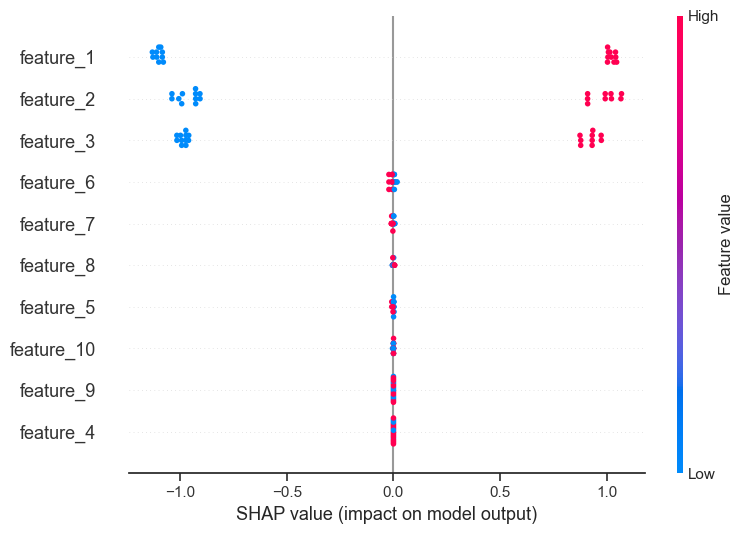

In [20]:
shap.summary_plot(shap_values, X_test, feature_names=test_data.columns)

In [21]:
mean_shap_values = (1 / shap_values.shape[0]) * np.abs(shap_values).sum(axis=0)

In [22]:
mean_shap_df = pd.DataFrame(columns=["mean_shap"], index=test_data.columns[:-1])
mean_shap_df["mean_shap"] = mean_shap_values

In [23]:
mean_shap_df = mean_shap_df.sort_values(by=["mean_shap"], ascending=True)

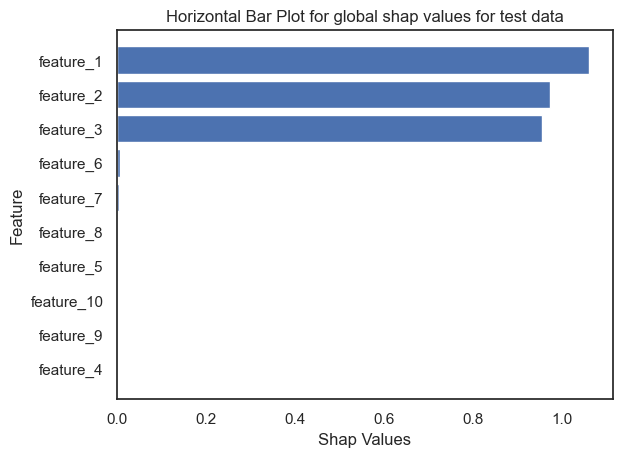

In [24]:
plt.barh(
    range(len(mean_shap_df.index)), mean_shap_df["mean_shap"].values, align="center"
)
plt.yticks(range(len(mean_shap_df.index)), mean_shap_df.index)
plt.xlabel("Shap Values")
plt.ylabel("Feature")
plt.title("Horizontal Bar Plot for global shap values for test data")
plt.show()

### Implementation of Shapley value calculation without using `SHAP` 

In [25]:
def get_feature_subsets_excluding_d(features, d):
    """
    Find all nonempty subsets from features which do not include feature d.
    """
    # Remove the feature d from the list of features
    features = [f for f in features if f != d]

    # Generate all possible subsets of the features
    all_subsets = []
    for subset_size in range(len(features) + 1):
        all_subsets.extend(combinations(features, subset_size))
    # Remove empty from subsets
    return list(all_subsets)[1:]

In [26]:
def calculate_shapley_value(model, data):
    """
    Calculates shapley values for all features for all data points, returns matix of shape (examples, features)
    """
    shapley_values = np.zeros(data.shape)
    n_features = data.shape[1]
    features = list(range(n_features))
    for feature_i in features:
        marginal_attribution = 0
        subsets_excluding_i = get_feature_subsets_excluding_d(features, feature_i)
        for subset in subsets_excluding_i:
            x_s_with_i = data.copy()
            x_s = data.copy()

            # shuffling the values for features to remove models dependence on that particular feature.
            for j in features:
                if j == feature_i:
                    np.random.shuffle(x_s[:, j])
                elif j not in list(subset):
                    np.random.shuffle(x_s_with_i[:, j])
                    np.random.shuffle(x_s[:, j])

            f_s_with_i = model.predict(x_s_with_i)
            f_s = model.predict(x_s)

            marginal_attribution += (
                (factorial(len(subset)) * factorial(n_features - len(subset) - 1))
                / factorial(n_features)
            ) * (f_s_with_i - f_s)
        shapley_values[:, feature_i] = marginal_attribution
    return shapley_values

In [27]:
implemented_shap_values = calculate_shapley_value(regressor, X_test)

In [28]:
implemented_shap_values.shape

(20, 10)

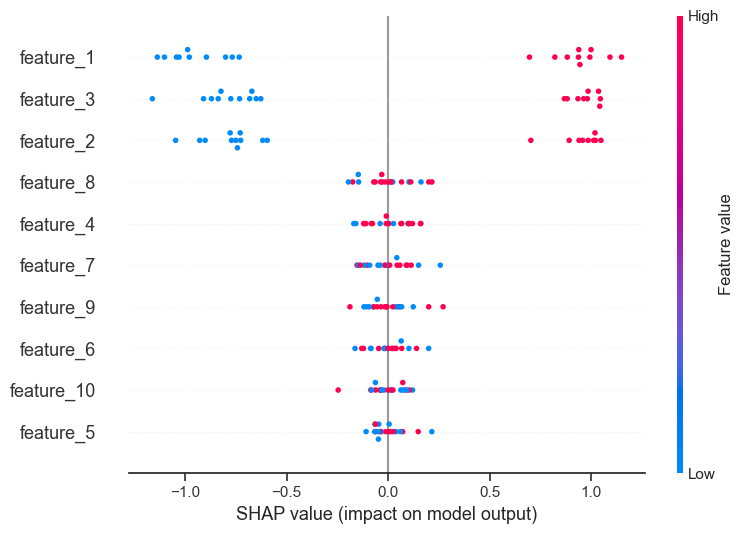

In [29]:
shap.summary_plot(implemented_shap_values, X_test, feature_names=test_data.columns)

In [30]:
implemented_mean_shap_values = (1 / implemented_shap_values.shape[0]) * np.abs(
    implemented_shap_values
).sum(axis=0)

In [31]:
implemented_mean_shap_df = pd.DataFrame(
    columns=["mean_shap"], index=test_data.columns[:-1]
)
implemented_mean_shap_df["mean_shap"] = implemented_mean_shap_values

In [32]:
implemented_mean_shap_df = implemented_mean_shap_df.sort_values(
    by=["mean_shap"], ascending=True
)

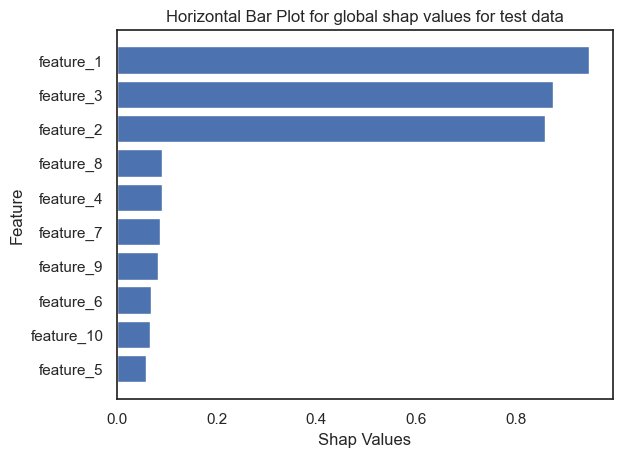

In [33]:
plt.barh(
    range(len(implemented_mean_shap_df.index)),
    implemented_mean_shap_df["mean_shap"].values,
    align="center",
)
plt.yticks(range(len(implemented_mean_shap_df.index)), implemented_mean_shap_df.index)
plt.xlabel("Shap Values")
plt.ylabel("Feature")
plt.title("Horizontal Bar Plot for global shap values for test data")
plt.show()

# (4%) DeepLIFT

In [34]:
def one_hidden_layer_nn(X, w1, w2):
    # Forward pass
    h1 = np.dot(X, w1)
    h2 = np.maximum(0, h1)  # ReLU activation
    output = np.dot(h2, w2)
    return h1, h2, output

In [35]:
def calculate_m_delta_x_delta_y(X, w1, w2, reference):
    # Forward pass
    h1, h2, output = one_hidden_layer_nn(X, w1, w2)
    reference_h1, reference_h2, reference_output = one_hidden_layer_nn(reference, w1, w2)
    # For calculation of multipliers
    # h1 = np.dot(X, w1) multiplier will be calculated according to the Linear Rule
    m_delta_i_delta_h1 = w1
    # h2 = np.maximum(0, h1) multiplier will be calculated according to the Rescale Rule
    # For avoiding division by zero 
    small_delta = 0.00000001
    m_delta_h1_delta_h2 = (h2 - reference_h2) / ((h1 - reference_h1)+ small_delta)
    # output = np.dot(h2, w2) multiplier will be calculated according to the Linear Rule
    m_delta_h2_delta_y = w2
    return (m_delta_i_delta_h1 * m_delta_h1_delta_h2 * m_delta_h2_delta_y).sum(axis=1)

In [36]:
def deepLIFT(dataset):
    reference_input = np.zeros((10,))
    w1 = np.ones((10, 2))
    w2 = np.ones((2,))
    attributions = []
    for i in range(dataset.shape[0]):
        input_x = dataset[i]
        # Setting non causal features to 0.
        input_x[3:] = 0
        delta_i = input_x - reference_input
        m_delta_i_delta_y = calculate_m_delta_x_delta_y(input_x, w1, w2, reference_input)
        attribution_delta_i_delta_y = np.multiply(delta_i, m_delta_i_delta_y)
        attributions.append(attribution_delta_i_delta_y)
    return np.array(attributions)

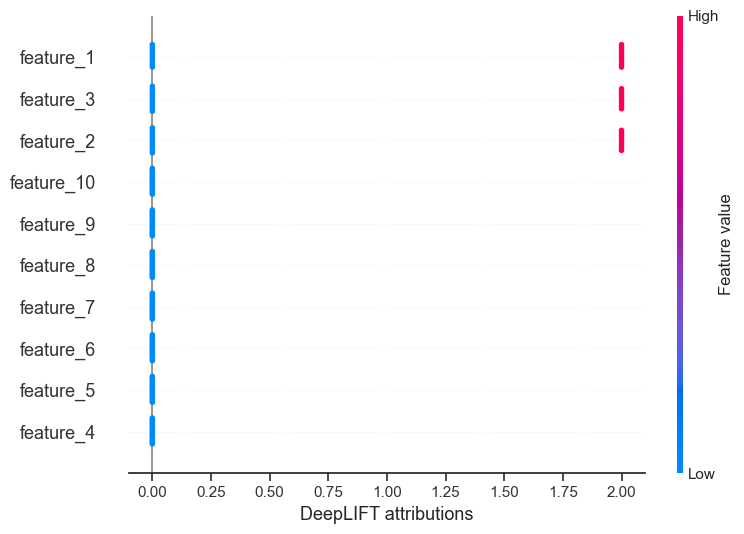

In [37]:
deeplift_attributions = deepLIFT(X_test) 
shap.summary_plot(deeplift_attributions, X_test, show=False, feature_names=test_data.columns)
plt.xlabel("DeepLIFT attributions")
plt.show()  # Show the plot

In [38]:
deeplift_mean_attribution_values = (1 / deeplift_attributions.shape[0]) * np.abs(
    deeplift_attributions
).sum(axis=0)

In [39]:
deeplift_mean_attribution_df = pd.DataFrame(
    columns=["mean_attributions"], index=test_data.columns[:-1]
)
deeplift_mean_attribution_df["mean_attributions"] = deeplift_mean_attribution_values

In [40]:
deeplift_mean_attribution_df = deeplift_mean_attribution_df.sort_values(
    by=["mean_attributions"], ascending=True
)

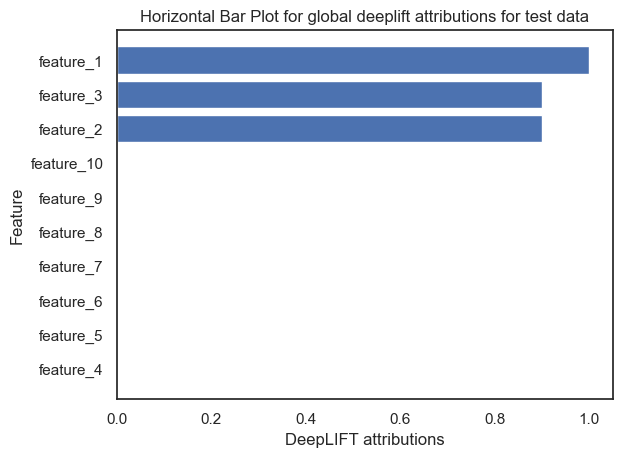

In [41]:
plt.barh(
    range(len(deeplift_mean_attribution_df.index)),
    deeplift_mean_attribution_df["mean_attributions"].values,
    align="center",
)
plt.yticks(range(len(deeplift_mean_attribution_df.index)), deeplift_mean_attribution_df.index)
plt.xlabel("DeepLIFT attributions")
plt.ylabel("Feature")
plt.title("Horizontal Bar Plot for global deeplift attributions for test data")
plt.show()